#**GESTIÓN DE LA SALUD EN USA, DESAFIOS QUE ENFRENTA COVID-19**


---




##Una entidad gubernamental responsable de la gestión de la salud en USA enfrenta el desafío de comprender y analizar la propagación del COVID-19 para tomar decisiones informadas y eficaces en la gestión de la pandemia. Como científico de datos, tu tarea es analizar los datos relacionados con el COVID-19 y presentar insights a través de visualizaciones que respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cómo ha evolucionado el Covid-19 en el país en comparación con el impacto observado a nivel global?

2. ¿Cuál ha sido la evolución de los nuevos casos diarios reportados de Covid-19 en el país a lo largo del tiempo?

3. ¿Cuál es la evolución del índice de letalidad del Covid-19 en el país, comparado con los países con los índices históricos más elevados?

4. Desde una perspectiva demográfica, ¿cuáles son las características que tienen un mayor impacto en el índice de letalidad de un país?

5. El Covid-19 en los paises según el desarrollo socio-económico. Comparativa

## **1. Configuración del ambiente**

In [62]:
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import requests
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import euclidean_distances
from sklearn.manifold import MDS

global df_covid_limpio

## **2. Obtención, Tratamiento y Análisis Exploratório (EDA)**

### **2.1 Cargando las bases de datos**

In [63]:
df_covid = pd.read_csv(StringIO(requests.get("https://covid19.who.int/WHO-COVID-19-global-data.csv").text))
df_population = pd.read_excel('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx', sheet_name=0, skiprows=16)
df_population = df_population[df_population['Year'] == 2019]

### **2.2 EDA Base Covid World Health Organization**

In [64]:
# Tratamiento de nulos
def exploracion_limpieza():

  global df_covid_limpio

  null_in_data =  df_covid.loc[:,"Country_code"].isnull().sum()

  if null_in_data > 0:
    df_covid_limpio = df_covid.dropna(subset=['Country_code'])
    df_covid_limpio.reset_index(inplace=True, drop=True)
  else:
    df_covid_limpio = df_covid.copy()

  df_covid_limpio = df_covid_limpio.loc[:,["Date_reported",
                                        "Country_code",
                                        "Country","New_cases",
                                        "Cumulative_cases",
                                        "New_deaths",
                                        "Cumulative_deaths"]]



  # Como no hay casos acumulativos y por consiguiente datos acumulativos de muerte,
  # la tasa de letalidad es igual a 0, pero como realizamos la división para todo
  # el dataframe, nos genero un nulo para esos casos, por tanto reemplazaremos esos
  # valores nulos con 0.

  # Sustituir todos los nulos de la porción del dataframe con la que trabajaremos

  null_in_all_data = df_covid_limpio.isnull().sum()

  if null_in_all_data.any():
    df_covid_limpio.fillna(0,inplace=True)
  else:
    df_covid_limpio = df_covid_limpio

  df_covid_limpio["lethality_rate"] = df_covid_limpio.Cumulative_deaths/df_covid_limpio.Cumulative_cases * 100

  # Sustituir todos los nulos de la porción del dataframe con la que trabajaremos
  null_in_leathality_rate = df_covid_limpio.lethality_rate.isnull().sum()

  if null_in_all_data.any():
    df_covid_limpio.fillna(0,inplace=True)
  else:
    df_covid_limpio = df_covid_limpio

  # Cambiar date_report a int
  df_covid_limpio["Date_reported"] = pd.to_datetime(df_covid_limpio["Date_reported"])

  Q0 =  df_covid_limpio.lethality_rate.quantile(0)
  Q99 = df_covid_limpio.lethality_rate.quantile(0.99)

  df_covid_limpio = df_covid_limpio[
      (df_covid_limpio["lethality_rate"]>= Q0) &
      (df_covid_limpio["lethality_rate"] <= Q99)]

  df_covid_limpio.reset_index(inplace=True,drop=True)

  return df_covid_limpio

df_covid_limpio = exploracion_limpieza()

In [65]:
df_covid_limpio

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
0,2020-01-05,AF,Afghanistan,0.0,0,0.0,0,0.000000
1,2020-01-12,AF,Afghanistan,0.0,0,0.0,0,0.000000
2,2020-01-19,AF,Afghanistan,0.0,0,0.0,0,0.000000
3,2020-01-26,AF,Afghanistan,0.0,0,0.0,0,0.000000
4,2020-02-02,AF,Afghanistan,0.0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...
48897,2023-12-24,ZW,Zimbabwe,23.0,266048,1.0,5731,2.154123
48898,2023-12-31,ZW,Zimbabwe,23.0,266071,0.0,5731,2.153936
48899,2024-01-07,ZW,Zimbabwe,46.0,266117,3.0,5734,2.154691
48900,2024-01-14,ZW,Zimbabwe,85.0,266202,3.0,5737,2.155130


{'whiskers': [<matplotlib.lines.Line2D at 0x7a92023853f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a9202384790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a92023843d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7a9202387820>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a9202384280>],
 'means': []}

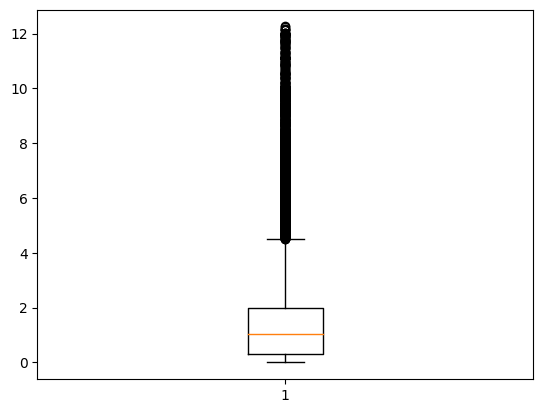

In [66]:
plt.boxplot(df_covid_limpio["lethality_rate"])

### **2.3 EDA Base Population United Nations**

In [67]:
# Escogiendo las columnas con las cuales vamos a trabajar en el data frame de df_population

df_population = df_population.loc[:,['ISO2 Alpha-code',
                                     'Total Population, as of 1 July (thousands)',
                                     'Male Population, as of 1 July (thousands)',
                                     'Female Population, as of 1 July (thousands)',
                                     'Population Density, as of 1 July (persons per square km)'
                                     ,'Life Expectancy at Birth, both sexes (years)']]

df_population = df_population.rename(columns={
    'ISO2 Alpha-code': 'Country_code',
    'Total Population, as of 1 July (thousands)': 'Total_Population',
    'Male Population, as of 1 July (thousands)': 'Male_Population',
    'Female Population, as of 1 July (thousands)': 'Female_Population',
    'Population Density, as of 1 July (persons per square km)': 'Population_Density',
    'Life Expectancy at Birth, both sexes (years)': 'Life_Expectancy'
  })

# nulos en las columnas, eliminación
nulls_in_data_population = df_population.isnull()
nulls_in_data_population

if nulls_in_data_population.any().any():
  df_population = df_population.dropna()
else:
  df_population = df_population

columnas = ["Total_Population",
            "Male_Population",
            "Female_Population",
            "Population_Density",
            "Life_Expectancy"]
for col in columnas:
    df_population[col] = pd.to_numeric(df_population[col], errors="coerce").fillna(0).astype(int)

columnas_2 = ["Total_Population",
              "Male_Population",
              "Female_Population"]
df_population[columnas_2]= df_population[columnas_2]*1000

df_population.reset_index(inplace=True,drop=True)

df_population_limpio = df_population

## **3 Preguntas y respuestas**

### **Pregunta 1**

In [68]:
#Agrupa por paises y luego de agruparlos, busca el valor máximo de cumulative para cada grupo agrupado. Luego pone un índice para hacerlo un df
total_por_pais = df_covid_limpio.groupby(df_covid_limpio.Country)['Cumulative_cases'].max().reset_index()
total_por_pais = total_por_pais.sort_values(by='Cumulative_cases', ascending=False)
total_por_pais

,Country,Cumulative_cases
222,United States of America,103436829
42,China,99326423
96,India,45023751
72,France,38997490
78,Germany,38437756
...,...,...
92,Holy See,26
163,Pitcairn,4
229,Yemen,1
212,Turkmenistan,0


In [69]:
top_10_paises = total_por_pais.head(10)
top_10_paises

,Country,Cumulative_cases
222,United States of America,103436829
42,China,99326423
96,India,45023751
72,France,38997490
78,Germany,38437756
28,Brazil,37519960
168,Republic of Korea,34571873
105,Japan,33803572
103,Italy,26693706
219,United Kingdom of Great Britain and Northern I...,24885790


In [70]:
total_por_paiss = total_por_pais[~total_por_pais['Country'].isin(top_10_paises['Country'])]
total_por_paiss

,Country,Cumulative_cases
171,Russian Federation,23773710
215,Türkiye,17004677
197,Spain,13980340
11,Australia,11752647
227,Viet Nam,11624000
...,...,...
92,Holy See,26
163,Pitcairn,4
229,Yemen,1
212,Turkmenistan,0


In [71]:
Otros = total_por_paiss.Cumulative_cases.sum()
Otros

291519855

In [72]:
top_10_paises = top_10_paises.append({'Country': 'Otros', 'Cumulative_cases': Otros}, ignore_index=True)

#Cambio del nombre de las columbas de reino unido y korea
indice_uk = top_10_paises.index[top_10_paises['Country'] == 'United Kingdom of Great Britain and Northern Ireland'].tolist()[0]
indice_ko = top_10_paises.index[top_10_paises['Country'] == 'Republic of Korea'].tolist()[0]
top_10_paises.at[indice_uk, 'Country'] = 'United Kingdom'
top_10_paises.at[indice_ko, 'Country'] = 'Korea'

<ipython-input-72-8205a3707ed8>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10_paises = top_10_paises.append({'Country': 'Otros', 'Cumulative_cases': Otros}, ignore_index=True)


In [73]:
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
top_5_paises = total_por_pais.nlargest(5)
df_covid_limpio_reset = df_covid_limpio.reset_index()
df_top_5 = df_covid_limpio_reset[df_covid_limpio_reset['Country'].isin(top_5_paises.index)]
total_acumulado_top_5 = df_top_5.pivot(index='Country', columns='Date_reported', values='Cumulative_cases').fillna(0)
total_acumulado_top_5

Date_reported,2020-01-05,2020-01-12,2020-01-19,2020-01-26,2020-02-02,2020-02-09,2020-02-16,2020-02-23,2020-03-01,2020-03-08,...,2023-11-19,2023-11-26,2023-12-03,2023-12-10,2023-12-17,2023-12-24,2023-12-31,2024-01-07,2024-01-14,2024-01-21
Country,,,,,,,,,,,,,,,,,,,,,
China,1.0,45.0,125.0,1985.0,14411.0,37251.0,68584.0,77042.0,79968.0,80859.0,...,99320035.0,99320425.0,99320845.0,99321242.0,99321637.0,99322142.0,99322727.0,99323756.0,99325108.0,99326423.0
France,0.0,0.0,0.0,3.0,6.0,12.0,12.0,16.0,16.0,16.0,...,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0,38997490.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,1075.0,...,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0,38437756.0
India,0.0,0.0,0.0,0.0,2.0,7.0,7.0,7.0,7.0,39.0,...,45001575.0,45001764.0,45002179.0,45003055.0,45004816.0,45008620.0,45013172.0,45018134.0,45021758.0,45023751.0
United States of America,0.0,0.0,0.0,7.0,9.0,20.0,24.0,40.0,73.0,464.0,...,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0,103436829.0


Text(0.5, -0.125, '\nEstados Unidos y China fueron los países con más contagios por Covid-19. Contaron con aproximadamente el doble de casos que el tercer país con más casos.\nEl incremento en la evolución de los casos de Estados Unidos fue similar al de resto de paises. Solo que este se tardó mucho más en estabilizarse.\n')

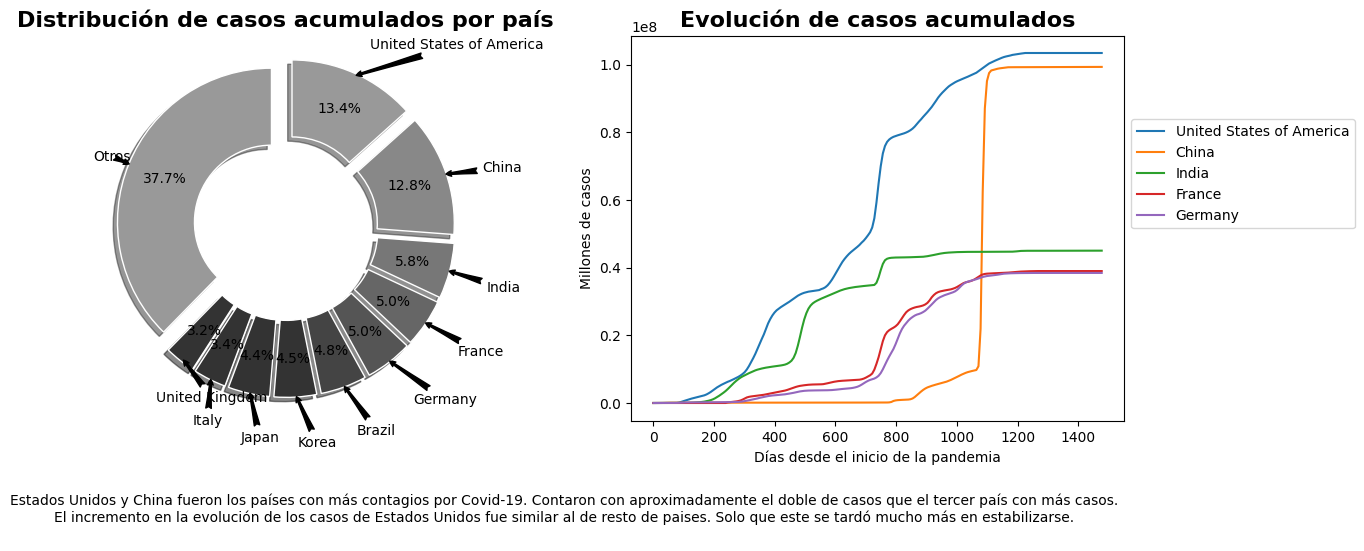

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
labels = top_10_paises['Cumulative_cases']
values = top_10_paises['Country']
colores = ['#999999', '#888888', '#777777', '#666666', '#555555', '#444444', '#333333', '#333333', '#333333', '#333333']
explode = explode = (0.1,) * len(labels)
wedges, texts, autotexts = axs[0].pie(labels, autopct='%1.1f%%', textprops={'fontsize': 10}, pctdistance=0.75, startangle=90, counterclock=False, wedgeprops=dict(width=0.5, edgecolor='w'), colors=colores, explode=explode, shadow=True)
line_scale = 2.0
for wedge, label, explode_value in zip(wedges, values, explode):
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x = line_scale * (1 - explode_value) * wedge.r * 1.2 * 0.5 * np.cos(angle * np.pi / 180)
    y = line_scale * (1 - explode_value) * wedge.r * 1.2 * 0.5 * np.sin(angle * np.pi / 180)
    axs[0].annotate(label, xy=(x, y), xytext=(1.25 * x, 1.25 * y), ha='left', va='top', arrowprops=dict(arrowstyle='fancy', color='black'))
axs[0].set_title('Distribución de casos acumulados por país', fontsize=16, fontweight='bold')

# Gráfico de Líneas
for pais in top_5_paises.index:
    days_since_start = (total_acumulado_top_5.columns - total_acumulado_top_5.columns[0]).days
    axs[1].plot(days_since_start, total_acumulado_top_5.loc[pais], label=pais)
    ultimo_valor = total_acumulado_top_5.loc[pais, total_acumulado_top_5.columns[-1]]
    posicion_etiqueta = (days_since_start[-1], ultimo_valor)
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 0.8))
axs[1].set_title('Evolución de casos acumulados', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Días desde el inicio de la pandemia')
axs[1].set_ylabel('Millones de casos')

conclusiones_distribucion = """
Estados Unidos y China fueron los países con más contagios por Covid-19. Contaron con aproximadamente el doble de casos que el tercer país con más casos.
El incremento en la evolución de los casos de Estados Unidos fue similar al de resto de paises. Solo que este se tardó mucho más en estabilizarse.
"""
plt.figtext(0.5, -0.125, conclusiones_distribucion, ha='center', fontsize=10)

### **Pregunta 2**

In [75]:
# 1. Tratamiento de los datos
grouped_df = df_covid_limpio.groupby(["Country", "Date_reported"])["Cumulative_cases"].sum().unstack()
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.set_index("Country")
grouped_df = grouped_df[(grouped_df.index == "United States of America")]
fechas = grouped_df.columns
new_cases = grouped_df[fechas].diff(axis=1).fillna(grouped_df[fechas]).sum(axis=0)
new_cases = pd.DataFrame(new_cases)
new_cases= new_cases[(new_cases[0]>0)]
new_cases

,0
Date_reported,
2020-01-26,7.0
2020-02-02,2.0
2020-02-09,11.0
2020-02-16,4.0
2020-02-23,16.0
...,...
2023-04-16,104057.0
2023-04-23,98467.0
2023-04-30,86484.0


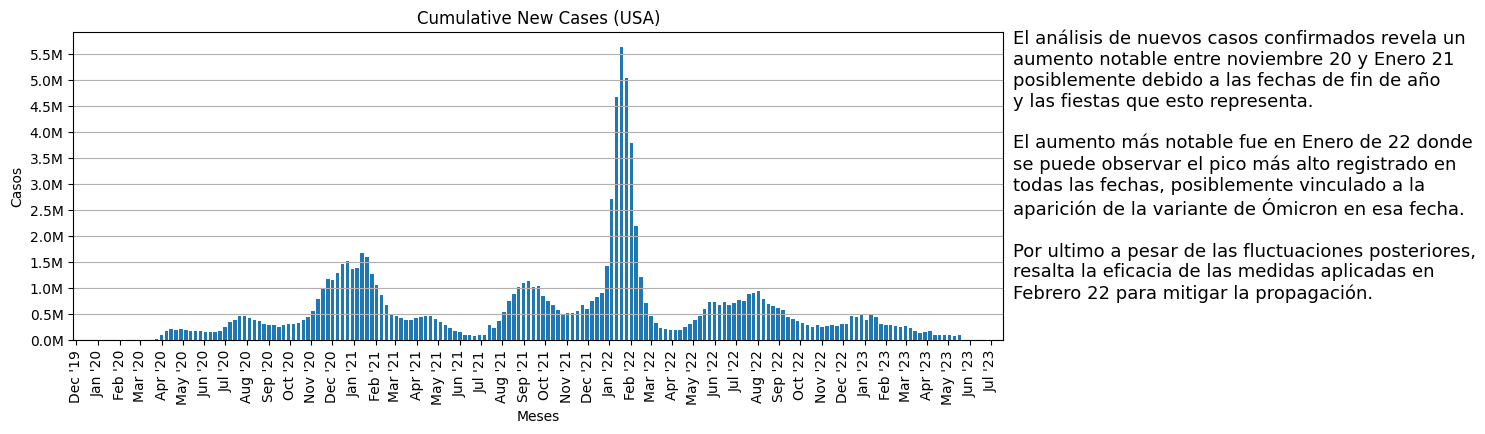

In [76]:
# 2. Visualización

fig, ax = plt.subplots(figsize=(12,4))
ejeX = new_cases.index
ejeY = new_cases[0]
ax.bar(ejeX, ejeY, align='edge', width=5)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=90)

# para ajustar los ticks del eje y a intervalos de 500000 y añade 'M' al final
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1f}M'.format(x*1e-6)))
ax.yaxis.set_ticks(range(0, int(max(new_cases[0])) + 1, 500000))


ax.set_title('Cumulative New Cases (USA)')
ax.set_xlabel('Meses')
ax.set_ylabel('Casos')
ax.text(1.957e4,8e5,"""El análisis de nuevos casos confirmados revela un
aumento notable entre noviembre 20 y Enero 21
posiblemente debido a las fechas de fin de año
y las fiestas que esto representa.

El aumento más notable fue en Enero de 22 donde
se puede observar el pico más alto registrado en
todas las fechas, posiblemente vinculado a la
aparición de la variante de Ómicron en esa fecha.

Por ultimo a pesar de las fluctuaciones posteriores,
resalta la eficacia de las medidas aplicadas en
Febrero 22 para mitigar la propagación.""", fontsize=13)
ax.grid(axis='y')

### **Pregunta 3**

In [77]:
def get_max_row(group, column):
    return group.loc[group[column].idxmax()]

# Letalidad total
result = (df_covid_limpio
          .groupby(['Country', df_covid_limpio['Date_reported'].dt.to_period("M")],
                   as_index=True)
          .apply(lambda group: get_max_row(group, 'lethality_rate'))
          )
result.reset_index(drop=True, inplace=True)
top4_countries = result.groupby('Country')['lethality_rate'].mean().nlargest(4).index
result = result[result.Country.isin(top4_countries)]

# Letalidad país seleccionado
result_us = (df_covid_limpio[df_covid_limpio['Country_code'] == 'US']
             .groupby(df_covid_limpio['Date_reported'].dt.to_period("M"),
                      as_index=True)
             .apply(lambda group: get_max_row(group, 'lethality_rate'))
             )
result_us.reset_index(drop=True, inplace=True)
result_final = pd.concat([result, result_us])

# AJutar nombres paises
country_mapping = {'Mexico': 'Mexico',
                   'Peru': 'Peru',
                   'Sudan': 'Sudan',
                   'Syrian Arab Republic': 'Syrian',
                   'United States of America': 'United States'}
result_final.Country = result_final.Country.map(country_mapping)

Text(2020-12-06 00:00:00, 12, '2020-03-11: OMS declara pandemia por covid-19')

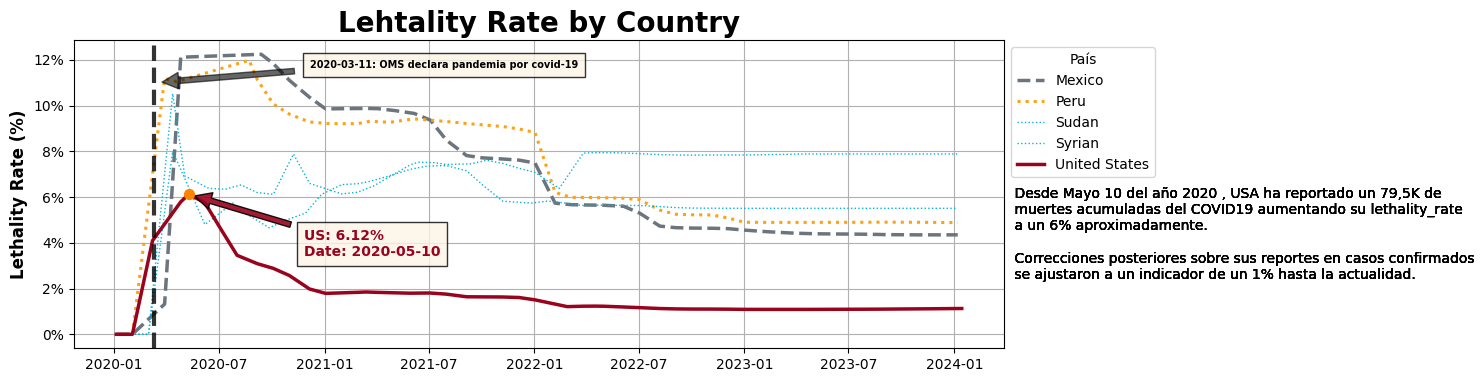

In [78]:
# Colores
colors = {
    'Mexico': '#6c757d',
    'Peru': '#fca311',
    'Sudan': '#00b4d8',
    'Syrian': '#00b4d8',
    'United States': '#9a031e'
}

# Tipos de linea
line_styles = {
    'Mexico': '--',
    'Peru': ':',
    'Sudan': ':',
    'Syrian': ':',
    'United States': 'solid'
}

# Tamaños de linea
line_widths = {
    'Mexico': 2.5,
    'Peru': 2.2,
    'Sudan': 1,
    'Syrian': 1,
    'United States': 2.5
}

# Maxima Letalidad en US
us_data = result_final.loc[result_final.Country == 'United States', ['Date_reported', 'lethality_rate']]
max_index = us_data.idxmax()
us_max_lr = us_data.loc[4].values

# Crea el gráfico de líneas
fig, ax = plt.subplots(figsize=(12, 4))

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

for pais in result_final['Country'].unique():
    country_data = result_final[result_final['Country'] == pais]

    ax.plot(country_data['Date_reported'],
            country_data['lethality_rate'],
            label=pais,
            color=colors[pais],
            linestyle=line_styles[pais],
            # marker="+",
            linewidth=line_widths[pais]
            )

    if pais == 'United States':
        ax.scatter(us_max_lr[0], us_max_lr[1], c='#fb8500', marker='o', s=50, zorder=3)

        plt.annotate(
            f'US: {round(us_max_lr[1], 2)}%\nDate: {us_max_lr[0].strftime("%Y-%m-%d")}',
            color='#9a031e',
            xy=(us_max_lr[0], us_max_lr[1]),
            xytext=(us_max_lr[0] + timedelta(days=200), us_max_lr[1] - 1.5),
            ha='left',
            va='top',
            weight='bold',
            arrowprops=dict(facecolor='#9a031e', shrink=0.05, alpha=0.9),
            bbox={'facecolor': 'oldlace', 'alpha': 0.8, 'pad': 5},
            zorder=2
        )
    ax.legend(title='País', bbox_to_anchor=(1,1))
    ax.grid()
    ax.set_title('Lehtality Rate by Country', fontdict={'fontsize':20, 'weight':'bold'})
    ax.set_ylabel('Lethality Rate (%)', fontdict={'fontsize':12, 'weight':'bold'})
    texto_conclusion =  """
                    Desde Mayo 10 del año 2020 , USA ha reportado un 79,5K de
                    muertes acumuladas del COVID19 aumentando su lethality_rate
                    a un 6% aproximadamente.

                    Correcciones posteriores sobre sus reportes en casos confirmados
                    se ajustaron a un indicador de un 1% hasta la actualidad.

                    """
    ax.text(196.75e2,1,texto_conclusion, fontsize=10)
plt.axvline(x=datetime(2020,3,11), lw=3, linestyle='--', color='black', alpha=0.8, zorder=3)
plt.annotate(
    f'{datetime(2020,3,11).strftime("%Y-%m-%d")}: OMS declara pandemia por covid-19',
    color='black',
    xy=(datetime(2020,3,11), 11),
    xytext=(datetime(2020,3,11) + timedelta(days=270), 12),
    ha='left',
    va='top',
    weight='bold',
    size=7,
    arrowprops=dict(facecolor='#000000', shrink=0.05, alpha=0.6),
    bbox={'facecolor': 'oldlace', 'alpha': 0.8, 'pad': 5}
)


### **Pregunta 4**

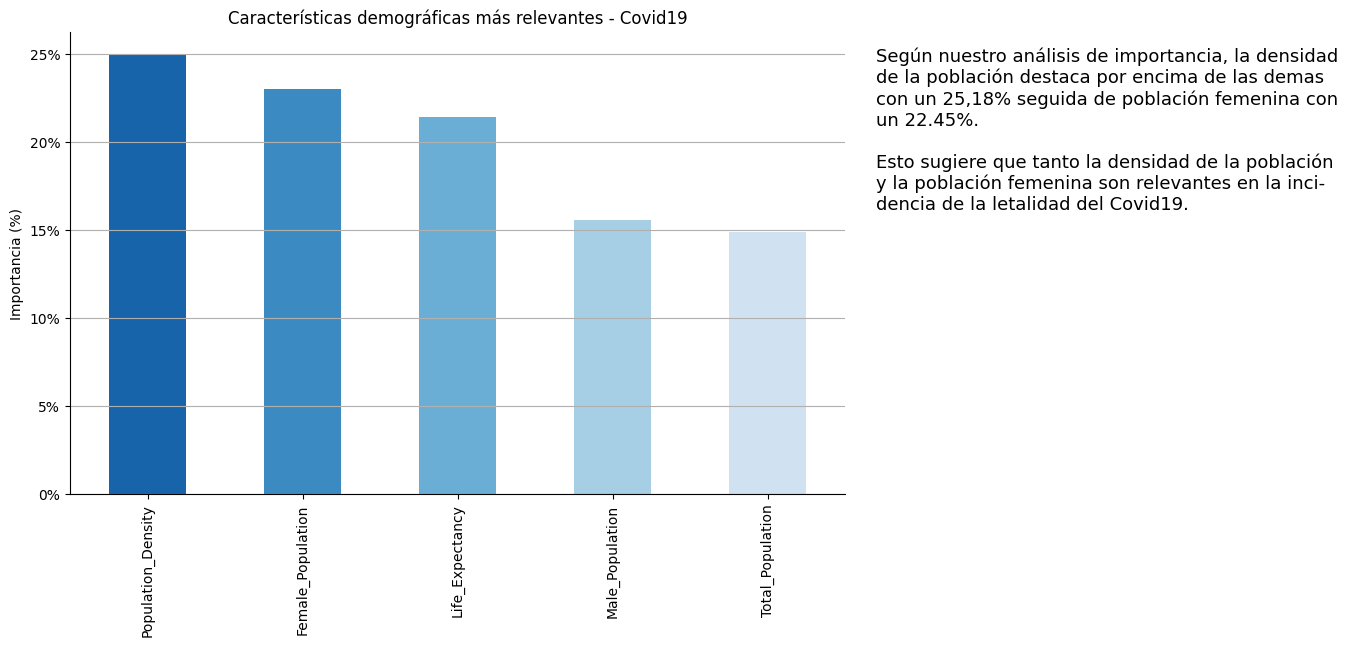

In [79]:
# 1. Tratamiento de los datos

df_filtrado = df_covid_limpio[df_covid_limpio.Date_reported <= "2020-12-31"]
df_agrupado = df_filtrado.groupby(["Country_code","Country"], as_index=False)["lethality_rate"].mean()
df_final = pd.merge(df_agrupado, df_population_limpio, on='Country_code', how='inner')
seleccion = ['lethality_rate', 'Total_Population', 'Male_Population', 'Female_Population', 'Population_Density', 'Life_Expectancy']
df_final = df_final[seleccion]
X = df_final.drop(['lethality_rate'], axis=1)
y = df_final['lethality_rate']
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances

# 2. Visualización

fig, ax = plt.subplots(figsize=(10, 6))
# Crea un mapa de colores con una gama de azules y el orden será desde el mayor más oscuro hasta el menor más claro
colores = plt.cm.Blues(np.linspace(0.8, 0.2, len(feature_importances)))

# Ordena feature_importances antes de graficar
feature_importances = feature_importances.sort_values(ascending=False)

# Grafica con las carácteristicas ordenadas y los colores correspondientes
feature_importances.plot(kind='bar', ax=ax, color=colores)

ax.set_title('Características demográficas más relevantes - Covid19')
ax.set_ylabel('Importancia (%)')
ax.set_xlabel('')

def porcentaje(x, _):
  rounded_value = round(x*100, 0)
  return f"{int(rounded_value):,}%"
ax.yaxis.set_major_formatter(FuncFormatter(porcentaje))

# Ahora haremos que los bordes negros del grafíco desaparezcan exceptuando el de la izquierda y el de abajo, para ello desactivaremos los spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.text(4.7,0.15,"""Según nuestro análisis de importancia, la densidad
de la población destaca por encima de las demas
con un 25,18% seguida de población femenina con
un 22.45%.

Esto sugiere que tanto la densidad de la población
y la población femenina son relevantes en la inci-
dencia de la letalidad del Covid19.
""", fontsize=13)
ax.grid(axis='y')

### **Pregunta 5**

In [80]:
# Ruta de los archivos adicionales
FILES = '../data/external/'

# Datos agrupados
df_filtrado = df_covid_limpio[df_covid_limpio.Date_reported <= "2020-12-31"]
df_agrupado = df_filtrado.groupby(["Country_code","Country"], as_index=False)["lethality_rate"].max()
df_final = pd.merge(df_agrupado, df_population_limpio, on='Country_code', how='inner')
seleccion = ['Country', 'Country_code', 'lethality_rate', 'Total_Population', 'Male_Population',
             'Female_Population', 'Population_Density', 'Life_Expectancy']
df_final = df_final[seleccion]
df_final = df_final.sort_values('Country_code', ascending=True)
df_final = df_final.drop('Country_code', axis=1)
df_final = df_final.reset_index(drop=True)
df_final.Country = df_final.Country.str.lower()
df_final = df_final.rename(columns={'Country': 'country'})

# Datos de vacunacion
cols = ['COUNTRY', 'ISO3', 'TOTAL_VACCINATIONS', 'PERSONS_VACCINATED_1PLUS_DOSE']
df_vaccination = pd.read_csv(f'vaccination-data.csv', usecols=cols)
df_vaccination = df_vaccination.rename(columns={'ISO3': 'Country_code'})
df_vaccination.columns = [col.lower() for col in df_vaccination.columns]
df_vaccination = df_vaccination.dropna(subset='total_vaccinations')
df_vaccination = df_vaccination.drop('total_vaccinations', axis=1)
df_vaccination = df_vaccination.sort_values('country_code', ascending=True)
df_vaccination = df_vaccination.reset_index(drop=True)
df_vaccination.country = df_vaccination.country.str.lower()

# Datos paises
cols = ['iso_code', 'median_age',
        'gdp_per_capita', 'cardiovasc_death_rate',
        'diabetes_prevalence', 'female_smokers', 'male_smokers',
        'hospital_beds_per_thousand','human_development_index']
df_covid_data = pd.read_csv(f'owid-covid-data.csv', usecols=cols)
df_covid_data = df_covid_data.rename(columns={'iso_code': 'country_code'})

df_covid_data_group = df_covid_data.groupby('country_code', as_index=False).mean()
df_covid_data_group = df_covid_data_group.dropna(thresh=2)
df_covid_data_group = df_covid_data_group.dropna(subset='gdp_per_capita')
df_covid_data_group = df_covid_data_group.sort_values('country_code', ascending=True)

# Datos finales
covid_merge = pd.merge(
    df_covid_data_group,
    df_vaccination,
    how='inner',
    on='country_code'
)

covid_merge = covid_merge.merge(
    df_final,
    how='inner',
    on='country'
)

covid_merge['population_vaccinated_rate'] = covid_merge.persons_vaccinated_1plus_dose / covid_merge.Total_Population * 100
covid_merge = covid_merge.drop('persons_vaccinated_1plus_dose', axis=1)

# Datos para modelo
cols = ['gdp_per_capita', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'human_development_index',
       'lethality_rate', 'Total_Population', 'Male_Population',
       'Female_Population', 'Population_Density', 'Life_Expectancy',
       'population_vaccinated_rate']
covid_merge_final = covid_merge.loc[:, cols]

In [81]:
# Imputacion de datos
imputer = KNNImputer(n_neighbors=5)
imputer.fit(covid_merge_final.hospital_beds_per_thousand.to_frame())
covid_merge_final.hospital_beds_per_thousand = imputer.transform(covid_merge_final.hospital_beds_per_thousand.to_frame())

imputer = KNNImputer(n_neighbors=5)
imputer.fit(covid_merge_final.human_development_index.to_frame())
covid_merge_final.human_development_index = imputer.transform(covid_merge_final.human_development_index.to_frame())

# Datos estandarizados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(covid_merge_final)
labels = [*scaler.get_feature_names_out()]
df_scaled_data = pd.DataFrame(scaled_data, columns=labels, index=covid_merge.country)

# Matriz de distancias
dis_matrix = euclidean_distances(df_scaled_data)

# Multidimensional Scaling
mds = MDS(n_components=2, random_state=2022, dissimilarity='precomputed')
mds_data = mds.fit_transform(dis_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [82]:
cols = ['country', 'country_code', 'gdp_per_capita', 'diabetes_prevalence',
        'hospital_beds_per_thousand', 'human_development_index',
       'lethality_rate', 'Total_Population', 'Male_Population',
       'Female_Population', 'Population_Density', 'Life_Expectancy',
       'population_vaccinated_rate']
mds_final = covid_merge.loc[:, cols]
mds_final['xcoord'] = mds_data[:, 0] * -1
mds_final['ycoord'] = mds_data[:, 1]

# Ordernar por lethality_rate
mds_final = mds_final.sort_values('lethality_rate', ascending=False)
mds_final = mds_final.reset_index(drop=True)

# Top20
mds_usa = mds_final.loc[mds_final.country_code == 'USA', :]
mds_final_top10 = mds_final.head(10).copy()
mds_final_lower10 = mds_final.tail(10).copy()

mds_final_top20 = pd.concat([mds_final_top10, mds_final_lower10, mds_usa], axis=0, ignore_index=True)
mds_final_top20 = mds_final_top20.reset_index(drop=True)

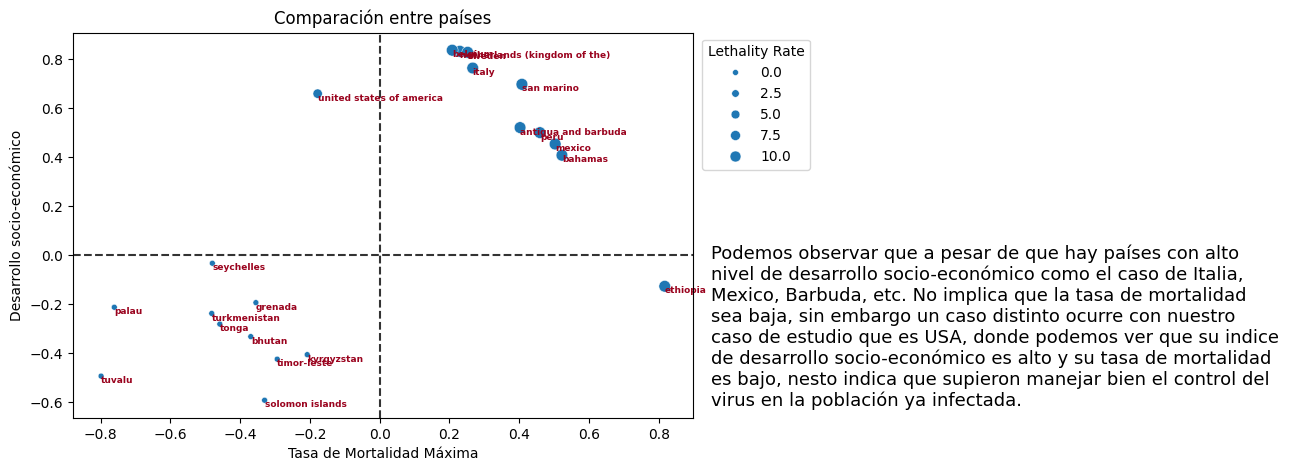

In [83]:
# Visualizacion
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    data=mds_final_top20,
    x='xcoord',
    y='ycoord',
    size='lethality_rate',
    ax=ax
)
labels = mds_final_top20.country
for label, gdp, x, y in zip(labels,
                            mds_final_top20.gdp_per_capita,
                            mds_final_top20.xcoord,
                            mds_final_top20.ycoord):
    plt.annotate(
        label,
        color='#9a031e',
        xy=(x, y),
        xytext=(x, y),
        ha='left',
        va='top',
        size=6.5,
        weight='bold',
        zorder=2
        )

plt.xlabel('Tasa de Mortalidad Máxima')
plt.ylabel('Desarrollo socio-económico')
plt.title('Comparación entre países')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8)
plt.legend(title='Lethality Rate', bbox_to_anchor=(1.2, 1))
texto_conclusion_5 =  """
Podemos observar que a pesar de que hay países con alto
nivel de desarrollo socio-económico como el caso de Italia,
Mexico, Barbuda, etc. No implica que la tasa de mortalidad
sea baja, sin embargo un caso distinto ocurre con nuestro
caso de estudio que es USA, donde podemos ver que su indice
de desarrollo socio-económico es alto y su tasa de mortalidad
es bajo, nesto indica que supieron manejar bien el control del
virus en la población ya infectada.
"""
ax.text(0.95,-0.7,texto_conclusion_5, fontsize=13)
plt.show()